# Writer Identification based on their Handwriting


In [1]:
#imports
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
import os
import pathlib

In [2]:
#paths
IAM_PATH = "/mounts/layout/dkvart/data/IAM"
CVL_PATH = "/mounts/layout/dkvart/data/CVL"

In [3]:
#Given a path to a directory, randomly display the samples 
def display_rand_images(PATH, R=4, C=2, size=(10,10)):
    temp = 0
    MAX_SHOW = R * C
    
    #matplot figure configuration
    figure = plt.figure(figsize=(size))
    data_dir = pathlib.Path(PATH)
    #create a numpy array and shuffle
    filenames = np.array(list(data_dir.glob('*')))
    np.random.shuffle(filenames)
    
    for i, filename in enumerate(filenames[:MAX_SHOW], 1):
        handwriting_sample = mpimg.imread(filename)
        figure.add_subplot(R, C, i)
        plt.imshow(handwriting_sample, cmap="gray")
    plt.show()

# IAM handwriting samples

In [4]:
display_rand_images(IAM_PATH)

<Figure size 720x720 with 0 Axes>

# CVL handwriting samples

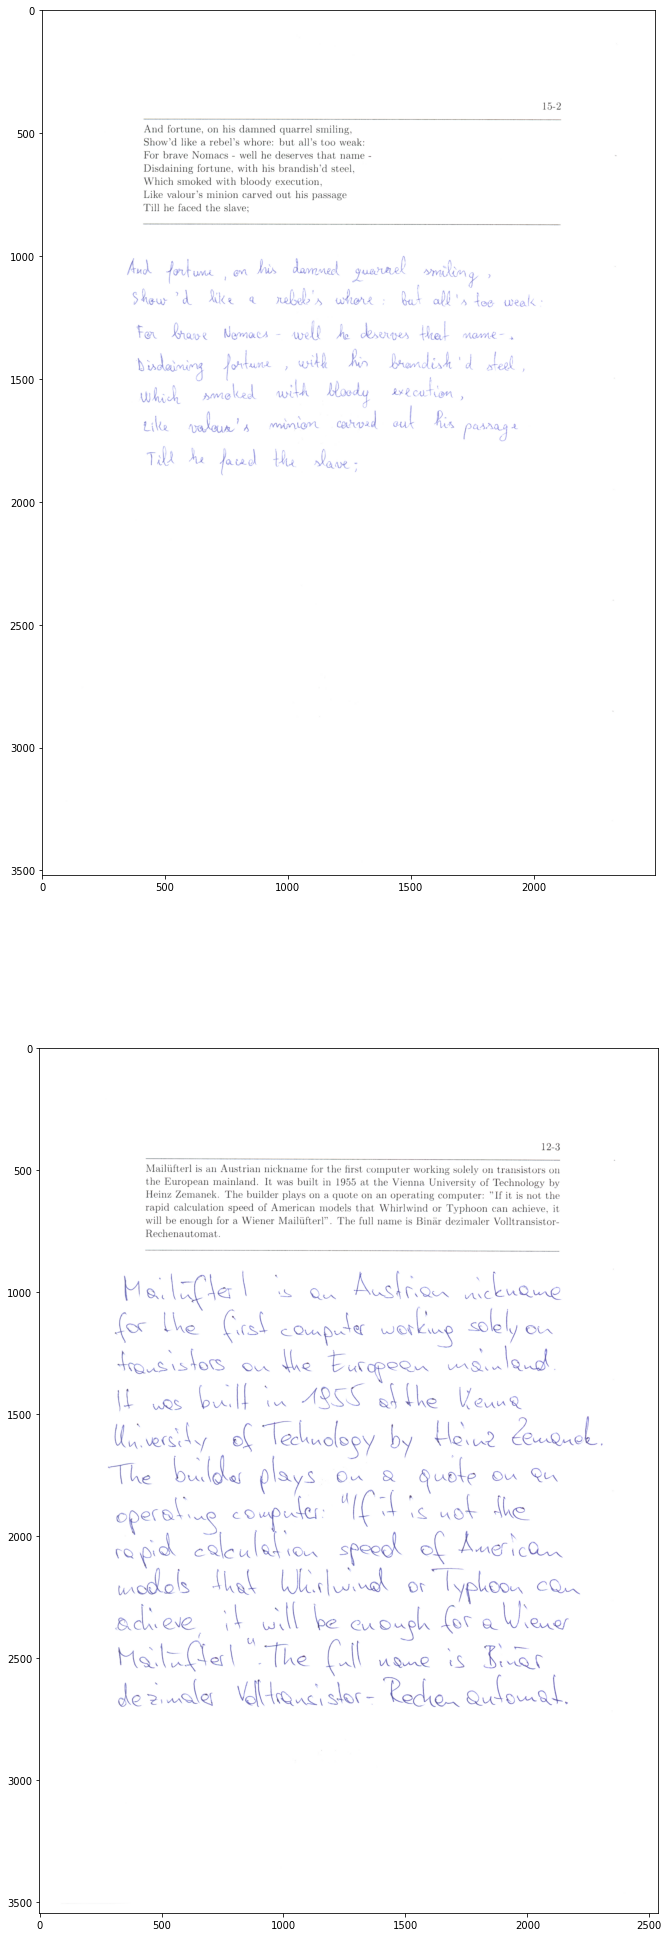

In [4]:
display_rand_images(CVL_PATH+"/trainset/pages/", R=2,C=1, size=(50,35))

In [16]:
def parse_filenames(DATA_ORIGIN, filenames):
    writer_ids = []
    for filename in filenames:
        if DATA_ORIGIN == "IAM":
            next_id = filename.split('-')[1][:3]
        elif DATA_ORIGIN == "CVL":
            next_id = filename.split('-')[0]
        
        writer_ids.append(int(next_id))
            
    return writer_ids

# Function: reads the directory structure. 
# Argument: a path to a directory where the data lives.
# Return: a tuple (writer_ids, filenames) where the first element is a numpy array of 
# writer ids and second element - a numpy array of each sample filename. These two arrays
# correspond to each other.
def read_all_samples(DATA_ORIGIN, PATH):
    filenames = os.listdir(PATH)    
    writer_ids = parse_filenames(DATA_ORIGIN, filenames)    
    
    return (np.array(writer_ids), np.array(filenames))            

In [21]:
writer_ids, sample_filenames = read_all_samples("CVL", CVL_PATH+"/trainset/words/") #DO I NEED THESE FUNCTIONS?
print(writer_ids[:4])
print(sample_filenames[:4])

[ 4 24 28 21]
['0004' '0024' '0028' '0021']


# Preprocessing DEPRECATED

In [5]:
import cv2

# Function: resizes an image to the specified new width, but also scales the 
#           image accordingly. 
def resize_image_to_width(img, NEW_WIDTH):
    h,w = img.shape
    NEW_HEIGHT = int((h/w)*NEW_WIDTH)
    return cv2.resize(img, (NEW_WIDTH, NEW_HEIGHT), interpolation = cv2.INTER_AREA)

# Function: Concatenate lines into one long page of a given width.
# Argument: PATH - to a directory with the images of lines.
#           NEW_WIDTH - the lines are of variable length, and all need to be resized to the same width.
def concatenate_lines(PATH, NEW_WIDTH):
    writer_ids, sample_filenames = read_all_samples("CVL", PATH)
    np.random.shuffle(sample_filenames)
    
    concatenated_image = cv2.imread(PATH+sample_filenames[0], cv2.IMREAD_GRAYSCALE)
    concatenated_image = resize_image_to_width(concatenated_image, NEW_WIDTH)
    
    for filename in sample_filenames[1:]:
        next_image = cv2.imread(PATH+filename, cv2.IMREAD_GRAYSCALE)
        
        #add a line to the final image, only if the 
        if(next_image.shape[1] < 2.5*NEW_WIDTH):
            continue
            
        resized_image = resize_image_to_width(next_image, NEW_WIDTH)      
        concatenated_image = cv2.vconcat([concatenated_image, resized_image])
        
    return concatenated_image

def split_image(img):
    images = []
    h, w = img.shape
    left = img[:, :w//3]
    mid = img[:, w//3:2*w//3]
    right = img[:, 2*w//3:]
    
    fixed_height = w//3
    for i in range(h//fixed_height-2):
        images.append(left[i*fixed_height:(i+1)*fixed_height, :])
        images.append(mid[(i+1)*fixed_height:(i+2)*fixed_height, :])
        images.append(right[(i+2)*fixed_height:(i+3)*fixed_height, :])
    
    return images

In [69]:
images = split_image(img)

These are the final patches that I acquired by splitting the image into three long stripes and then cutting them horizontally in a way that I get the square images. They contain 8-15 words. I think this might be too much variability.

In [6]:
def save_images(PATH, writer_id, images):
    counter = 0
    os.mkdir(PATH+writer_id)
    for image in images:
        counter+=1
        filename = PATH+writer_id+'/'+writer_id+'-'+str(counter)+'.jpg'
        cv2.imwrite(filename, image)
        
def create_patches(N):
    PATH = CVL_PATH+"/trainset/lines/"
    directories = os.listdir(PATH)
    for writer_id in directories:
        all_patches = []
        for i in range(N): #Doing this N times, produces more data
            conc_image = concatenate_lines(PATH+writer_id+'/', 600)
            mini_patches = split_image(conc_image)
            all_patches.extend(mini_patches)
        save_images(CVL_PATH+"/trainset/processed/", writer_id, all_patches)

In [7]:
create_patches(2)

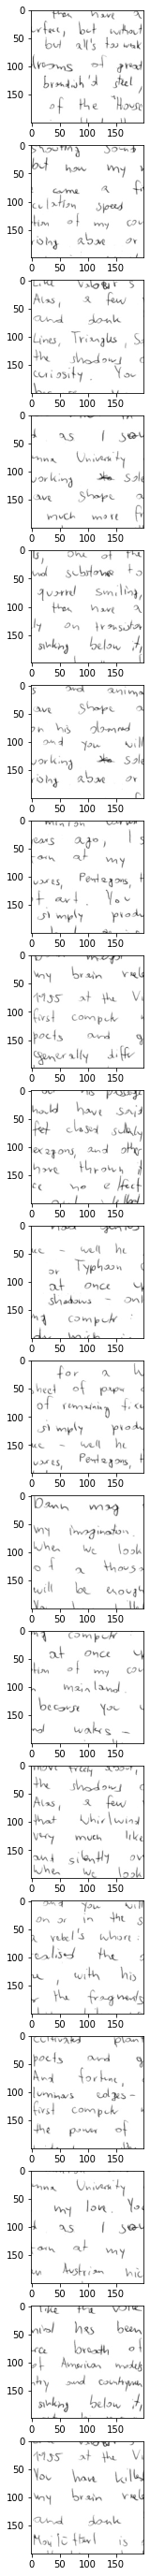

In [8]:
display_rand_images(CVL_PATH+"/trainset/processed/0001/", R=19, C=1, size=(20,50))

# Preprocessing 
Adopted from Tang and Wu 2016

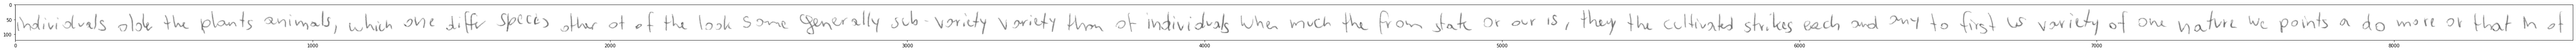

In [15]:
def sample_id(stem):
    return int(stem.split('-')[1])
# Given a path to a directory that stores the images of words for a single writer, 
# reads all the images, and organizes them into a dictionary of arrays where each dict[i]
# represents a collection of words for a single handwriting sample (Note that each writer has
# multiple handwriting samples)
# Argument: PATH -> to a directory that stores words written by a single writer
from collections import defaultdict
import cv2
def read_and_organize_filenames(PATH):#for CVL dataset
    directory = pathlib.Path(PATH)
    result_dict = defaultdict(list)
    
    for filename in directory.glob('*.tif'):
        s_id = sample_id(filename.stem)
        result_dict[s_id].append(filename)
        
    return result_dict
        
dct = read_and_organize_filenames(CVL_PATH+'/trainset/words/0001/')
# Return an image with a fixed height
# by padding with white pixels. 
def equalize_height(HEIGHT,padding, img):
    h = img.shape[0]
    w = img.shape[1]
    background = np.zeros((HEIGHT, w+padding), np.uint8)
    background += 255
#     print(background[HEIGHT//2-w//2:HEIGHT//2+w//2, :].shape)
    background[HEIGHT//2-h//2:HEIGHT//2+h//2, 0:w] = img[0:2*(h//2) ,:]
    return background

# Given an array of filenames pointing to images of single words,
# randomly permutes the filenames, reads the images, concatenates them
# and returns a single image -> a line of handwriting
def produce_random_line(list_of_word_filenames):
    PAD_SIZE = 30
    HEIGHT = 120
    list_of_word_filenames = np.array(list_of_word_filenames)
    np.random.shuffle(list_of_word_filenames)
    concatenated_image = np.zeros((HEIGHT,1), np.uint8)
#     concatenated_image = cv2.imread(str(list_of_word_filenames[0]), cv2.IMREAD_GRAYSCALE)
#     HEIGHT = concatenated_image.shape[0]+30
#     concatenated_image = equalize_height(HEIGHT,PAD_SIZE,concatenated_image)
    for filename in list_of_word_filenames:
        img = cv2.imread(str(filename), cv2.IMREAD_GRAYSCALE)
        if(img.shape[0] < HEIGHT):
            padded_img = equalize_height(HEIGHT,PAD_SIZE, img)
            concatenated_image = cv2.hconcat([concatenated_image, padded_img])
#         else:
#             print(filename)
    return concatenated_image
        
image = produce_random_line(dct[4])
plt.figure(figsize=(100,100))
plt.imshow(image, cmap='gray')
# plt.show()

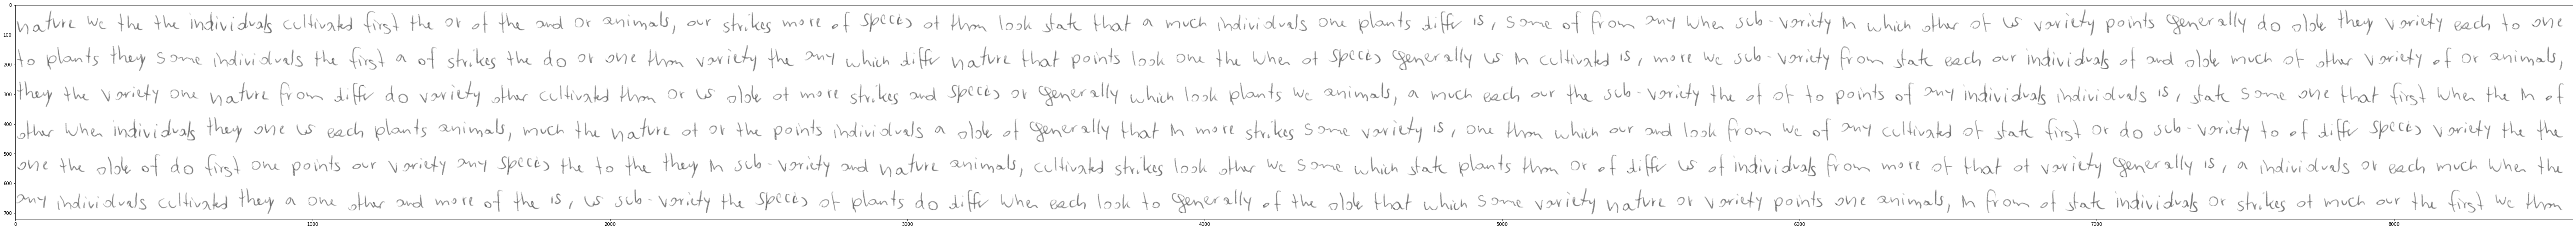

In [16]:
def produce_page(list_of_word_filenames, L):
    concatenated_image = produce_random_line(list_of_word_filenames)
    for i in range(L-1):
        next_line = produce_random_line(list_of_word_filenames)
#         print(next_line.shape)
        concatenated_image = cv2.vconcat([concatenated_image, next_line])
    return concatenated_image
image = produce_page(dct[4], 6)
plt.figure(figsize=(100,100))
plt.imshow(image, cmap='gray')
plt.show()

202


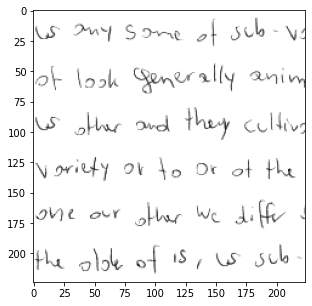

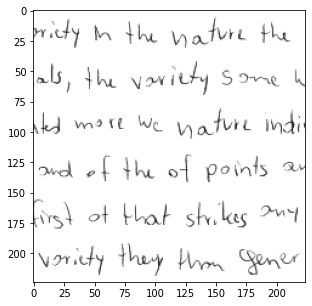

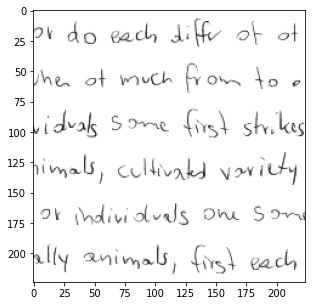

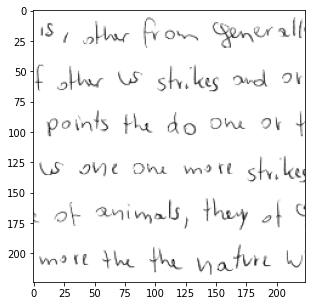

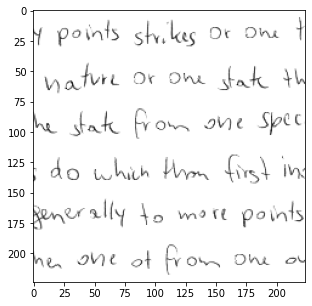

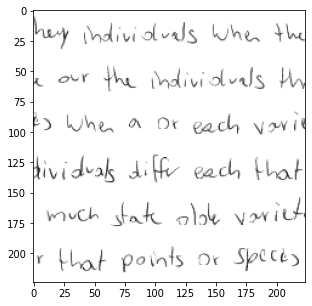

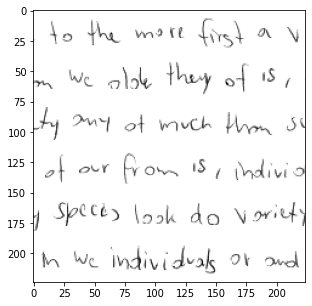

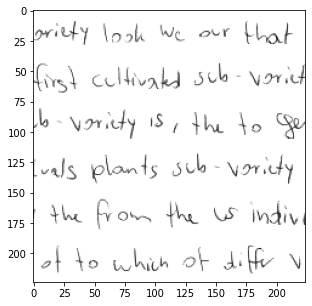

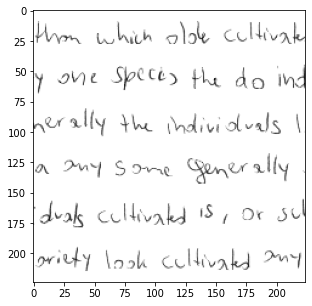

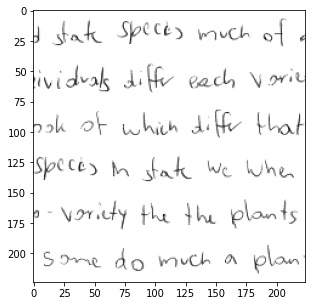

In [40]:
PATCH_DIM = 224
def produce_patches(dct, N):
    L = 6
    result = []
    
    for sample_id, lst in dct.items():
        for i in range(N):#number of pages constructed
            page = produce_page(lst, L)
        #         plt.figure(figsize=(100,100))
        #         plt.imshow(page, cmap='gray')

            h = page.shape[0]
            w = page.shape[1]
            num_patches = w//h
            #produce square images of size h*h
            for i in range(num_patches-1):
                next_patch = page[:,i*h:(i+1)*h]
                next_patch = cv2.resize(next_patch, (PATCH_DIM, PATCH_DIM))
                result.append(next_patch)

    return result

res = produce_patches(dct, N=2)
print(len(res))
for im in res[:10]:
    plt.figure(figsize=(5,5))
    plt.imshow(im, cmap='gray')
plt.show()

In [92]:
def preprocess_and_save(PATH, OUT_PATH, N):
    directory = pathlib.Path(PATH)
    #for each writer
    for folder in directory.glob('*'):
        writer_id = folder.stem
        dct = read_and_organize_filenames(str(folder))
        patch_batch = produce_patches(dct, N)
        os.mkdir(OUT_PATH+'/'+writer_id)
        counter = 0

        for patch in patch_batch:
            counter += 1
            out_filename = OUT_PATH+'/'+writer_id+'/'+writer_id+'-'+str(counter)+'.jpg'
            cv2.imwrite(out_filename, patch)
        print("Successfully saved all patches for writer", writer_id)
        

In [ ]:
preprocess_and_save(CVL_PATH+'/trainset/words', CVL_PATH+"/trainset/processed", N=10) 

# Regular classification via CNN

In [3]:
from tensorflow.keras import datasets, layers, models

In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Number of images: 27390
/mounts/layout/dkvart/data/CVL/trainset/processed/0001/0001-1.jpg
224 224


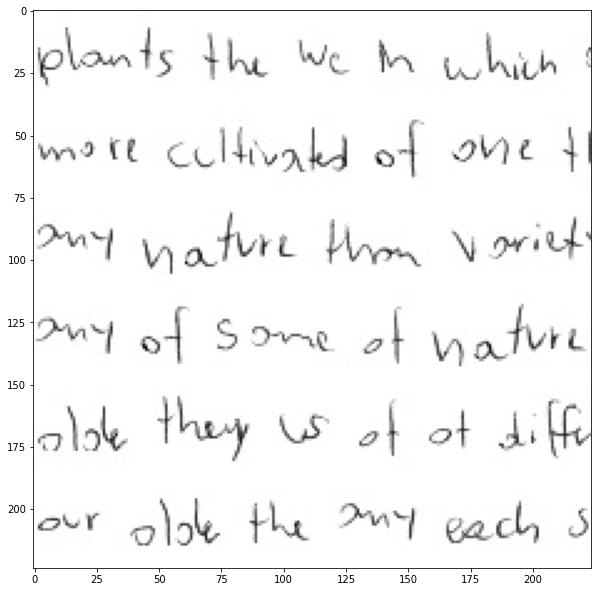

In [5]:
data_dir = pathlib.Path(CVL_PATH+"/trainset/processed")

image_count = len(list(data_dir.glob('*/*.jpg')))
print("Number of images:", image_count)

filename = next(data_dir.glob('0001/*'))
print(filename)
image = mpimg.imread(filename)

plt.figure(figsize=(10, 20))
plt.imshow(image, cmap='gray')

batch_size = 16
img_height, img_width = image.shape
print(img_height, img_width)

In [62]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  label_mode='categorical',
  subset="training",
  color_mode='grayscale',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27390 files belonging to 27 classes.
Using 24651 files for training.


In [63]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  label_mode='categorical',
  subset="validation",
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27390 files belonging to 27 classes.
Using 2739 files for validation.


In [64]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['0001', '0002', '0003', '0004', '0005', '0006', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0041', '0042', '0047', '0050']
27


In [55]:
for im_batch, lab_batch in val_ds:
    print(im_batch.shape)
    print(lab_batch.shape)
    print(lab_batch[0])
    break
# plt.imshow(im_batch[5], cmap='gray')

(16, 224, 224, 1)
(16, 27)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.], shape=(27,), dtype=float32)


In [56]:
model = models.Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)))
model.add(layers.Conv2D(32, (7, 7), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(96, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(128, (1, 1), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(0.00003),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=batch_size, shuffle=True)

Epoch 1/50
1541/1541 [==============================] - 66s 43ms/step - loss: 3.1261 - accuracy: 0.0815 - val_loss: 2.4641 - val_accuracy: 0.1464
Epoch 2/50
1541/1541 [==============================] - 65s 42ms/step - loss: 2.1224 - accuracy: 0.2475 - val_loss: 2.1854 - val_accuracy: 0.1774
Epoch 3/50
1541/1541 [==============================] - 66s 43ms/step - loss: 1.9383 - accuracy: 0.2825 - val_loss: 2.3015 - val_accuracy: 0.1712
Epoch 4/50
1541/1541 [==============================] - 65s 42ms/step - loss: 1.8533 - accuracy: 0.3079 - val_loss: 2.1414 - val_accuracy: 0.2012
Epoch 5/50
1541/1541 [==============================] - 65s 42ms/step - loss: 1.8083 - accuracy: 0.3232 - val_loss: 2.2290 - val_accuracy: 0.2001
Epoch 6/50
1541/1541 [==============================] - 65s 42ms/step - loss: 1.7672 - accuracy: 0.3375 - val_loss: 2.0420 - val_accuracy: 0.2570
Epoch 7/50
1541/1541 [==============================] - 66s 43ms/step - loss: 1.7190 - accuracy: 0.3551 - val_loss: 2.0415 -

# Triplet loss CNN

In [6]:
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [7]:
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  color_mode='grayscale',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27390 files belonging to 27 classes.
Using 21912 files for training.


In [8]:
class_names = train_ds.class_names
print(class_names)

['0001', '0002', '0003', '0004', '0005', '0006', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0041', '0042', '0047', '0050']


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27390 files belonging to 27 classes.
Using 5478 files for validation.


In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 1)
(32,)


In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
num_classes = 27
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(32, (7, 7), activation='relu'),
  layers.MaxPooling2D((3, 3)),
  layers.Conv2D(64, (5, 5), activation='relu'),
  layers.MaxPooling2D((3, 3)),
  layers.Dropout(0.3),
  layers.Conv2D(128, (1, 1), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(256, activation=None),
  layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
])

In [13]:
import tensorflow_addons as tfa

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00003),
    loss=tfa.losses.TripletSemiHardLoss())

In [14]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=200
)

Epoch 1/200
685/685 [==============================] - 43s 63ms/step - loss: 0.9959 - val_loss: 0.9986
Epoch 2/200
685/685 [==============================] - 41s 60ms/step - loss: 0.9957 - val_loss: 0.9983
Epoch 3/200
685/685 [==============================] - 41s 60ms/step - loss: 0.9956 - val_loss: 0.9922
Epoch 4/200
685/685 [==============================] - 41s 60ms/step - loss: 0.9644 - val_loss: 0.9322
Epoch 5/200
685/685 [==============================] - 41s 60ms/step - loss: 0.9387 - val_loss: 0.9043
Epoch 6/200
685/685 [==============================] - 41s 60ms/step - loss: 0.9159 - val_loss: 0.8732
Epoch 7/200
685/685 [==============================] - 41s 60ms/step - loss: 0.8558 - val_loss: 0.7835
Epoch 8/200
685/685 [==============================] - 42s 61ms/step - loss: 0.8063 - val_loss: 0.7431
Epoch 9/200
685/685 [==============================] - 41s 60ms/step - loss: 0.7660 - val_loss: 0.7063
Epoch 10/200
685/685 [==============================] - 42s 61ms/step - l

Epoch 80/200
685/685 [==============================] - 42s 61ms/step - loss: 0.2451 - val_loss: 0.2688
Epoch 81/200
685/685 [==============================] - 41s 60ms/step - loss: 0.2402 - val_loss: 0.2785
Epoch 82/200
685/685 [==============================] - 41s 60ms/step - loss: 0.2376 - val_loss: 0.2736
Epoch 83/200
685/685 [==============================] - 41s 60ms/step - loss: 0.2338 - val_loss: 0.2656
Epoch 84/200
685/685 [==============================] - 41s 59ms/step - loss: 0.2334 - val_loss: 0.2629
Epoch 85/200
685/685 [==============================] - 41s 60ms/step - loss: 0.2259 - val_loss: 0.2601
Epoch 86/200
685/685 [==============================] - 41s 60ms/step - loss: 0.2258 - val_loss: 0.2645
Epoch 87/200
685/685 [==============================] - 41s 60ms/step - loss: 0.2217 - val_loss: 0.2622
Epoch 88/200
685/685 [==============================] - 41s 59ms/step - loss: 0.2180 - val_loss: 0.2615
Epoch 89/200
685/685 [==============================] - 41s 60ms

685/685 [==============================] - 42s 61ms/step - loss: 0.0666 - val_loss: 0.0841
Epoch 159/200
685/685 [==============================] - 41s 60ms/step - loss: 0.0623 - val_loss: 0.0776
Epoch 160/200
685/685 [==============================] - 41s 60ms/step - loss: 0.0612 - val_loss: 0.0804
Epoch 161/200
685/685 [==============================] - 41s 60ms/step - loss: 0.0583 - val_loss: 0.0748
Epoch 162/200
685/685 [==============================] - 41s 60ms/step - loss: 0.0589 - val_loss: 0.0726
Epoch 163/200
685/685 [==============================] - 41s 60ms/step - loss: 0.0572 - val_loss: 0.0734
Epoch 164/200
685/685 [==============================] - 41s 59ms/step - loss: 0.0555 - val_loss: 0.0679
Epoch 165/200
685/685 [==============================] - 40s 59ms/step - loss: 0.0543 - val_loss: 0.0646
Epoch 166/200
685/685 [==============================] - 41s 60ms/step - loss: 0.0531 - val_loss: 0.0656
Epoch 167/200
685/685 [==============================] - 40s 59ms/ste

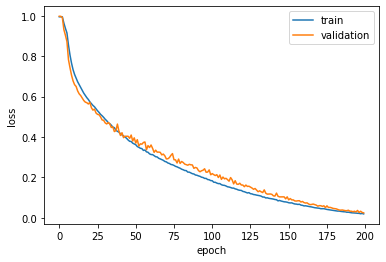

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [16]:
model.save('/mounts/layout/dkvart/models/current')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /mounts/layout/dkvart/models/current/assets


In [17]:
import numpy as np
import io

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
out_v = open('vecs.tsv', 'a')

#save vectors and metadata into csv files
for imgs, labels in val_ds:
    imgs = imgs.numpy()
    labels = labels.numpy()
    results = model.predict(imgs)
    np.savetxt(out_v, results, delimiter='\t')
    [out_m.write(str(x) + "\n") for x in labels]#actual labels
out_m.close()
out_v.close()

try:
    from google.colab import files
    files.download('vecs.tsv')
    files.download('meta.tsv')
except:
    pass

In [93]:
preprocess_and_save(CVL_PATH+'/testset/words', CVL_PATH+"/testset/processed", N=1) 

Successfully saved all patches for writer 0602
Successfully saved all patches for writer 0612
Successfully saved all patches for writer 0251
Successfully saved all patches for writer 0187
Successfully saved all patches for writer 0245
Successfully saved all patches for writer 0937
Successfully saved all patches for writer 0157
Successfully saved all patches for writer 0199
Successfully saved all patches for writer 0243
Successfully saved all patches for writer 0920
Successfully saved all patches for writer 0214
Successfully saved all patches for writer 0175
Successfully saved all patches for writer 0432
Successfully saved all patches for writer 0510
Successfully saved all patches for writer 0238
Successfully saved all patches for writer 0198
Successfully saved all patches for writer 0080
Successfully saved all patches for writer 0255
Successfully saved all patches for writer 0285
Successfully saved all patches for writer 0399
Successfully saved all patches for writer 0909
Successfully 

Successfully saved all patches for writer 0152
Successfully saved all patches for writer 0235
Successfully saved all patches for writer 0413
Successfully saved all patches for writer 0156
Successfully saved all patches for writer 0163
Successfully saved all patches for writer 0299
Successfully saved all patches for writer 0932
Successfully saved all patches for writer 0535
Successfully saved all patches for writer 0166
Successfully saved all patches for writer 0965
Successfully saved all patches for writer 0571
Successfully saved all patches for writer 0894
Successfully saved all patches for writer 0217
Successfully saved all patches for writer 0077
Successfully saved all patches for writer 0387
Successfully saved all patches for writer 0374
Successfully saved all patches for writer 0717
Successfully saved all patches for writer 0192
Successfully saved all patches for writer 0191
Successfully saved all patches for writer 0479
Successfully saved all patches for writer 0540
Successfully 

In [18]:
test_data_dir = data_dir = pathlib.Path(CVL_PATH+"/testset/processed")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  color_mode='grayscale',
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20935 files belonging to 283 classes.


In [96]:
class_names = test_ds.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['0052', '0053', '0057', '0058', '0059', '0073', '0074', '0075', '0076', '0077', '0078', '0079', '0080', '0081', '0083', '0084', '0095', '0096', '0097', '0098', '0152', '0153', '0155', '0156', '0157', '0161', '0162', '0163', '0164', '0165', '0166', '0167', '0168', '0169', '0170', '0171', '0172', '0173', '0175', '0176', '0177', '0178', '0179', '0180', '0181', '0182', '0183', '0184', '0185', '0186', '0187', '0188', '0189', '0190', '0191', '0192', '0193', '0194', '0195', '0196', '0197', '0198', '0199', '0200', '0201', '0202', '0203', '0204', '0205', '0206', '0207', '0208', '0209', '0210', '0211', '0212', '0213', '0214', '0215', '0216', '0217', '0218', '0219', '0220', '0221', '0222', '0223', '0224', '0227', '0228', '0229', '0230', '0231', '0232', '0233', '0234', '0235', '0236', '0237', '0238', '0239', '0240', '0241', '0242', '0243', '0244', '0245', '0246', '0247', '0248', '0249', '0250', '0251', '0252', '0254', '0255', '0256', '0262', '0263', '0265', '0285', '0286', '0287', '0288', '0289',

In [19]:
out_m = io.open('meta_test.tsv', 'w', encoding='utf-8')
out_v = open('vecs_test.tsv', 'a')

#save vectors and metadata into csv files
for imgs, labels in test_ds:
    imgs = imgs.numpy()
    labels = labels.numpy()
    results = model.predict(imgs)
    np.savetxt(out_v, results, delimiter='\t')
    [out_m.write(str(x) + "\n") for x in labels]#actual labels
out_m.close()
out_v.close()

try:
    from google.colab import files
    files.download('vecs_test.tsv')
    files.download('meta_test.tsv')
except:
    pass